In [1]:
from PIL import Image
import os
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
import numpy as np
# Directory containing images with unusual extensions
data_dir = 'YaleFaces/'

# Function to read images with unusual extensions and convert to OpenCV format
def read_images(directory):
    person_images_dic = {}
    for filename in os.listdir(directory):
        if filename.startswith('subject'):  # Adjust the extension as per your dataset
            filepath = os.path.join(directory, filename)
            with Image.open(filepath) as img:
                # Convert image to numpy array
                # img=img.resize((  10,  10))
                np_image = np.array(img)
                if filename[:9] in person_images_dic:
                    person_images_dic[filename[:9]][filename]=np_image
                else:
                    person_images_dic[filename[:9]]={}
                    person_images_dic[filename[:9]][filename]=np_image
    return person_images_dic

# Read images from the specified directory
person_images_dic = read_images(data_dir)

In [2]:
# from PIL import Image
# import os
# import cv2
# import numpy as np
# from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import roc_curve, auc
# import numpy as np
# # Directory containing images with unusual extensions
# data_dir = 'YaleFaces/'

# # Function to read images with unusual extensions and convert to OpenCV format
# def read_images(directory):
#     images = []
#     labels=[]
#     for filename in os.listdir(directory):
#         if filename.startswith('subject'):  # Adjust the extension as per your dataset
#             filepath = os.path.join(directory, filename)
#             with Image.open(filepath) as img:
#                 # Convert image to numpy array
#                 img=img.resize((100,100))
#                 np_image = np.array(img)
#                 images.append(np_image)
#                 labels.append(filename)
#     return images,labels

# # Read images from the specified directory
# images,labels = read_images(data_dir)

In [3]:
# print(person_images_dic.keys())

In [4]:
# from matplotlib import pyplot as plt

# # Display images from each subject in 3 rows
# fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 rows, 5 columns

# # Dictionary to store the index of the first image for each subject
# subject_indices = {}

# # Counter for the current row and column
# row_index = 0
# col_index = 0

# # Iterate through the image labels
# for filename in labels:
#     subject = filename.split('.')[0]  # Extract the subject number from the filename
    
#     # If the subject is encountered for the first time, assign a new index and display the image
#     if subject not in subject_indices:
#         subject_indices[subject] = (row_index, col_index)
#         axes[row_index, col_index].imshow(images[labels.index(filename)], cmap='gray')
#         axes[row_index, col_index].axis('off')
#         axes[row_index, col_index].set_title(subject)
        
#         # Update row and column indices
#         col_index += 1
#         if col_index == 5:  # Move to the next row if the current row is filled
#             row_index += 1
#             col_index = 0
            
#     # Break the loop if we have displayed one image for each subject
#     if len(subject_indices) == 15:
#         break

# plt.tight_layout()
# plt.show()



In [46]:
class Eigenfaces:
    def __init__(self):
        self.pca_compunant_dictionary={}
        self.eigenValues, self.eigenVectors=None,None
        self.min_distance_threshould=None
        
    def fit(self,X,y,Eigen_threshold=0.90,min_distance_threshould=25):
        self.min_distance_threshould=min_distance_threshould
        flatten_images=[cv2.resize(image, (100, 100)).flatten() for image in X]
        flatten_images = np.vstack(flatten_images)
        self.mean_image=np.mean(flatten_images, axis=0)
        self.flatten_images_centroid = flatten_images - self.mean_image
        coverance_matrix=(self.flatten_images_centroid.T@self.flatten_images_centroid)/(len(X)-1)        
        self.eigenValues, self.eigenVectors = np.linalg.eig(coverance_matrix)
        self.eigenValues_sum=sum(self.eigenValues)
        used_eigenValues=[]
        self.used_eigenVectors=[]
        zipped_data = list(zip(self.eigenValues,self.eigenVectors))
        # zipped_data.sort(reverse=True)
        # self.eigenValues, self.eigenVectors = zip(*zipped_data)
        indices = np.argsort([eigenValue for eigenValue, _ in zipped_data])[::-1]
        self.eigenValues = np.array([self.eigenValues[i] for i in indices])
        self.eigenVectors = np.array([self.eigenVectors[i] for i in indices])
        print(len(self.eigenVectors))
        print(len(self.eigenValues))
        print(self.eigenValues)
        # self.flatten_images_centroid=flatten_images
        self.y=y

        reached_sum=0
        for i,j in zip(self.eigenValues, self.eigenVectors):
            if(reached_sum<Eigen_threshold*self.eigenValues_sum):
                used_eigenValues.append(i)
                self.used_eigenVectors.append(j)
                reached_sum+=i
            else:
                break
        for i,label in enumerate(self.y):
            self.pca_compunant_dictionary[label]=[]
            for vector in self.used_eigenVectors:
                weight=(self.flatten_images_centroid[i])@vector
                self.pca_compunant_dictionary[label].append(weight)

    def change_threshould(self,Eigen_threshold=None,min_distance_threshould=None):
        if self.eigenValues is None:
            print("you should fit model first")
        else:
            if Eigen_threshold is None and min_distance_threshould is None:
                print("no change happend")
            else:
                if min_distance_threshould is not None:
                    self.min_distance_threshould=min_distance_threshould
                if Eigen_threshold is not None:
                    reached_sum=0
                    used_eigenValues=[]
                    self.used_eigenVectors=[]
                    for i,j in zip(self.eigenValues, self.eigenVectors):
                        if(reached_sum<Eigen_threshold*self.eigenValues_sum):
                            self.used_eigenVectors.append(j)
                            reached_sum+=i
                        else:
                            break
                    for i,label in enumerate(self.y):
                        self.pca_compunant_dictionary[label]=[]
                        for vector in self.used_eigenVectors:
                            weight=(self.flatten_images_centroid[i])@vector
                            self.pca_compunant_dictionary[label].append(weight)
                    print(len(self.used_eigenVectors))
                print("changes saved")
            


    def predict(self, X):
        predictions = []
        for x in X:
            x_flat = cv2.resize(x, (100, 100)).flatten()
            value_weights = []
            for vector in self.used_eigenVectors:
                weight = (x_flat - self.mean_image) @ vector
                value_weights.append(weight)
            label_distance_dic = {}
            for label, weights in self.pca_compunant_dictionary.items():
                distance = np.sqrt(np.sum((np.array(weights) - np.array(value_weights)) ** 2))
                label_distance_dic[label] = distance
            sorted_dict = sorted(label_distance_dic.items(), key=lambda item: item[1])
            if abs(sorted_dict[0][1])>self.min_distance_threshould:
                predictions.append("not in the data set")
            else:
                predictions.append(sorted_dict[0][0][:9])  #   Take the top prediction
        return predictions
    
    def score(self, X, y):
        predictions = self.predict(X)
        correct = sum(1 for pred, true in zip(predictions, y) if pred == true[:9] )
        return correct / len(y)



    def confusion_matrix(self,X,y):
        confusion_matrix_dic={}
        predictions = self.predict(X)
        confusion_matrix_dic["not in the data set"]={"true_positive":0,"false_negative":0}
        confusion_matrix_dic["sum"]={"true_positive":0,"false_negative":0}
        for index,true in enumerate(y):
            if true[:9] not in confusion_matrix_dic:
                confusion_matrix_dic[true[:9]]={"true_positive":0,"false_negative":0}
            if true[:9]==predictions[index]:
                confusion_matrix_dic[true[:9]]["true_positive"]+=1
                confusion_matrix_dic["sum"]["true_positive"]+=1
            else:
                confusion_matrix_dic[true[:9]]["false_negative"]+=1
                confusion_matrix_dic["sum"]["false_negative"]+=1
        return confusion_matrix_dic
    
    def roc(self, X, y, Eigen_threshold_list=None, min_distance_threshould_list=None):
        if Eigen_threshold_list is None and min_distance_threshould_list is None:
            raise ValueError("Both Eigen_threshold_list and min_distance_threshould_list are None.")
        else:
            Eigen_threshold_roc = {}
            min_distance_threshould_roc = {}

            if Eigen_threshold_list is not None:
                for threshold in Eigen_threshold_list:
                    self.change_threshould(Eigen_threshold=threshold)
                    confusion_matrix_dic = self.confusion_matrix(X, y)
                    for person_class in confusion_matrix_dic.keys():
                        if person_class != "not in the data set" and person_class != "sum":
                            if person_class not in Eigen_threshold_roc:
                                Eigen_threshold_roc[person_class] = []
                            Sensitivity = confusion_matrix_dic[person_class]["true_positive"] / (
                                        confusion_matrix_dic[person_class]["true_positive"] +
                                        confusion_matrix_dic[person_class]["false_negative"])
                            Specificity = (confusion_matrix_dic["sum"]["true_positive"] -
                                        confusion_matrix_dic[person_class]["true_positive"]) / (
                                                (confusion_matrix_dic["sum"]["true_positive"] -
                                                confusion_matrix_dic[person_class]["true_positive"]) +
                                                (confusion_matrix_dic["sum"]["false_negative"] -
                                                confusion_matrix_dic[person_class]["false_negative"]))
                            Eigen_threshold_roc[person_class].append((1 - Specificity, Sensitivity))
                            print(confusion_matrix_dic["sum"]["true_positive"]+confusion_matrix_dic["sum"]["false_negative"])

            if min_distance_threshould_list is not None:
                for threshold in min_distance_threshould_list:
                    self.change_threshould(min_distance_threshould=threshold)
                    confusion_matrix_dic = self.confusion_matrix(X, y)
                    for person_class in confusion_matrix_dic.keys():
                        if person_class != "not in the data set" and person_class != "sum":
                            if person_class not in min_distance_threshould_roc:
                                min_distance_threshould_roc[person_class] = []
                            Sensitivity = confusion_matrix_dic[person_class]["true_positive"] / (
                                        confusion_matrix_dic[person_class]["true_positive"] +
                                        confusion_matrix_dic[person_class]["false_negative"])
                            Specificity = (confusion_matrix_dic["sum"]["true_positive"] -
                                        confusion_matrix_dic[person_class]["true_positive"]) / (
                                                (confusion_matrix_dic["sum"]["true_positive"] -
                                                confusion_matrix_dic[person_class]["true_positive"]) +
                                                (confusion_matrix_dic["sum"]["false_negative"] -
                                                confusion_matrix_dic[person_class]["false_negative"]))
                            min_distance_threshould_roc[person_class].append((1 - Specificity, Sensitivity))

        return Eigen_threshold_roc, min_distance_threshould_roc


In [47]:
import random
from sklearn.model_selection import train_test_split

random.seed(42)
selected_persons = random.sample(list(person_images_dic.keys()), 13)
unselected_persons=list(set(list(person_images_dic.keys())).difference(set(selected_persons)))
# Dictionary to store selected persons and their images
selected_persons_images =[]
X_train_total, X_test_total, y_train_total, y_test_total=[],[],[],[]

# # Iterate over selected persons
for person in selected_persons:

    labels = list(person_images_dic[person].keys())
    images=list(person_images_dic[person].values())
    X_train,X_test , y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train_total+=X_train
    X_test_total+=X_test
    y_train_total+=y_train
    y_test_total+=y_test


In [7]:
# import joblib


In [48]:
from sklearn.model_selection import train_test_split, cross_validate

classi=Eigenfaces()
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
classi.fit(X_train_total,y_train_total)
# print(classi.predict_proba(X_test))
# print(labels[:154])
# print(labels[154:])
# print()

10000
10000
[ 1.35401013e+07+0.j  7.46586772e+06+0.j  4.43568121e+06+0.j ...
 -1.21123423e-09+0.j -1.32795076e-09+0.j -1.41055586e-09+0.j]


In [49]:
print(classi.predict(X_test_total))
print(classi.score(X_test_total,y_test_total))
# correct = sum(1 for pred, true in zip(classi.predict(X_test), y_test) if pred[0][:9] == true[:9] )
# print(correct / len(y_test))
# print(y_test)

['subject04', 'subject11', 'subject11', 'subject02', 'subject02', 'subject02', 'subject01', 'subject11', 'subject12', 'subject12', 'subject12', 'subject12', 'subject05', 'subject05', 'subject05', 'subject04', 'subject04', 'subject04', 'subject10', 'subject10', 'subject10', 'subject03', 'subject04', 'subject08', 'subject06', 'subject06', 'subject06', 'subject12', 'subject13', 'subject13', 'subject08', 'subject08', 'subject15', 'subject07', 'subject07', 'subject07', 'subject08', 'subject08', 'subject13']
0.7692307692307693


In [50]:
print(classi.roc(X=X_test_total,y=y_test_total,Eigen_threshold_list=[0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975],min_distance_threshould_list=[0,5,10,15,20,25,30]))

9
changes saved
39
39
39
39
39
39
39
39
39
39
39
39
39
11
changes saved
39
39
39
39
39
39
39
39
39
39
39
39
39
13
changes saved
39
39
39
39
39
39
39
39
39
39
39
39
39
16
changes saved
39
39
39
39
39
39
39
39
39
39
39
39
39
20
changes saved
39
39
39
39
39
39
39
39
39
39
39
39
39
26
changes saved
39
39
39
39
39
39
39
39
39
39
39
39
39
36
changes saved
39
39
39
39
39
39
39
39
39
39
39
39
39
52
changes saved
39
39
39
39
39
39
39
39
39
39
39
39
39
changes saved
changes saved
changes saved
changes saved
changes saved
changes saved
changes saved
({'subject11': [(0.4444444444444444, 0.0), (0.38888888888888884, 0.6666666666666666), (0.5277777777777778, 0.6666666666666666), (0.3055555555555556, 0.3333333333333333), (0.2222222222222222, 0.6666666666666666), (0.25, 0.0), (0.4444444444444444, 0.0), (0.5833333333333333, 0.0)], 'subject02': [(0.4722222222222222, 0.3333333333333333), (0.38888888888888884, 0.6666666666666666), (0.5, 0.3333333333333333), (0.33333333333333337, 0.6666666666666666), (0.25,

In [61]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming clf is your trained classifier and X_test, y_test are your test data and labels
# clf.predict(X_test) should return the predicted class for each sample in X_test

# Step 2: Making predictions
y_pred = classi.predict(X_test_total)

# Step 3: Confusion Matrix
conf_matrix = confusion_matrix(y_test_total, y_pred)

# Step 4: ROC Curve
n_classes = 14
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # One vs all approach
    y_true_onevsall = np.array([1 if label == i else 0 for label in y_test])
    y_score_onevsall = np.array([1 if label == i else 0 for label in y_pred])
    fpr[i], tpr[i], _ = roc_curve(y_true_onevsall, y_score_onevsall)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] # Add more colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


ValueError: Found input variables with inconsistent numbers of samples: [3, 39]

9
changes saved
11
changes saved
13
changes saved
16
changes saved
20
changes saved
26
changes saved
36
changes saved
52
changes saved
changes saved
changes saved
changes saved
changes saved
changes saved
changes saved
changes saved


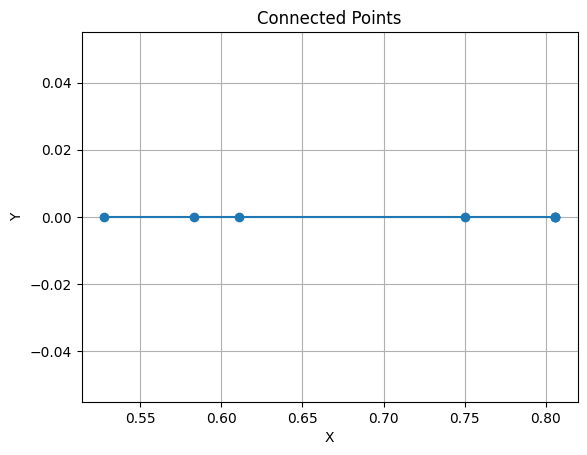

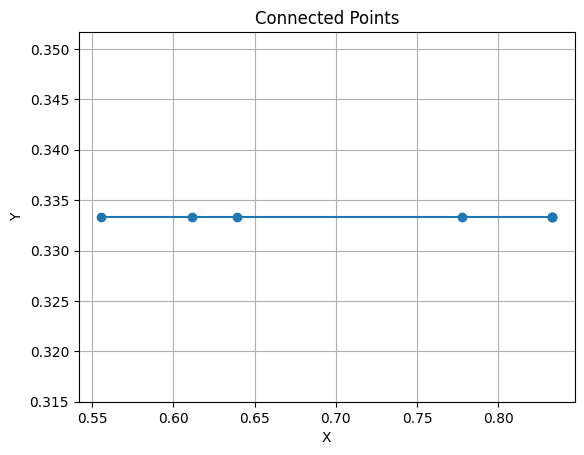

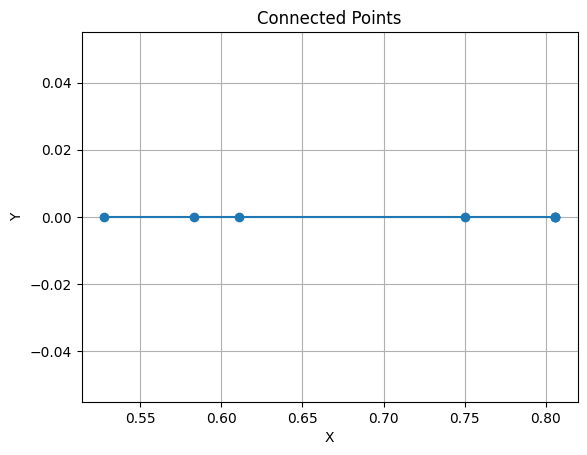

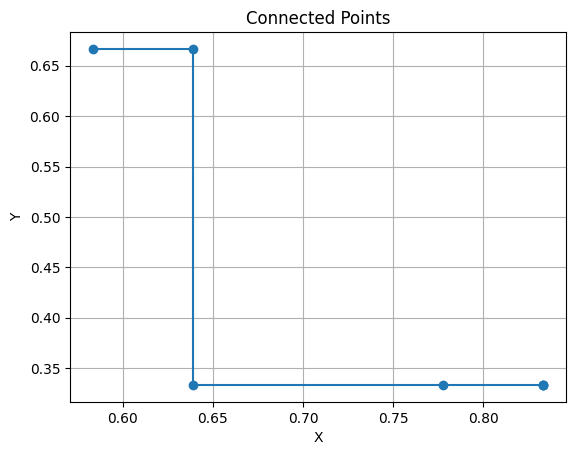

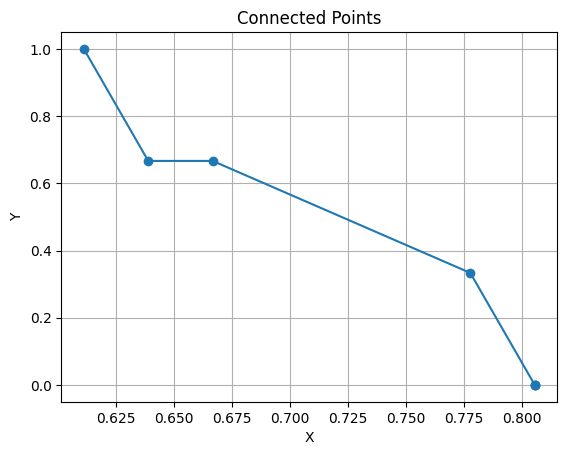

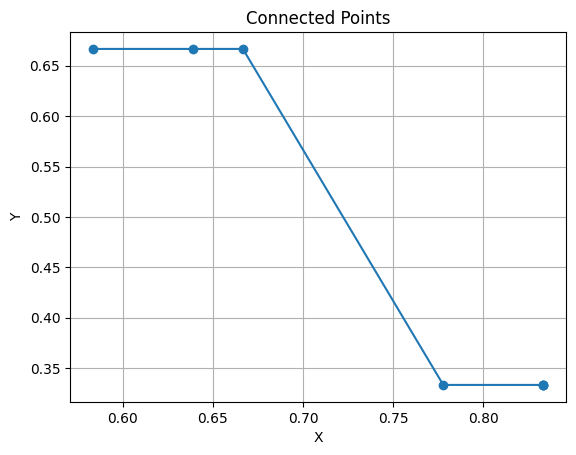

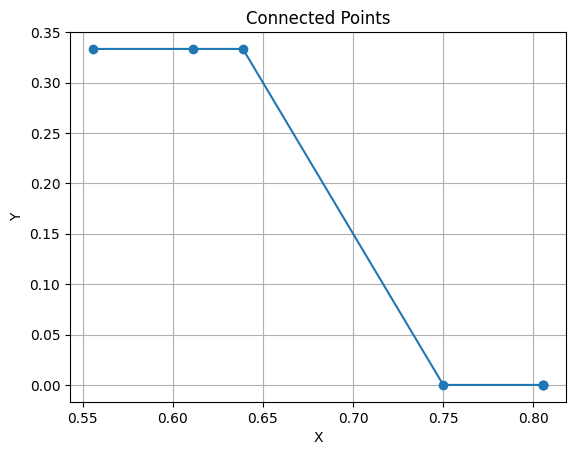

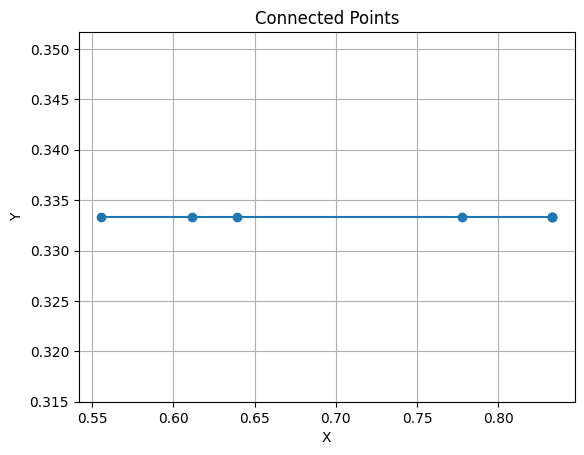

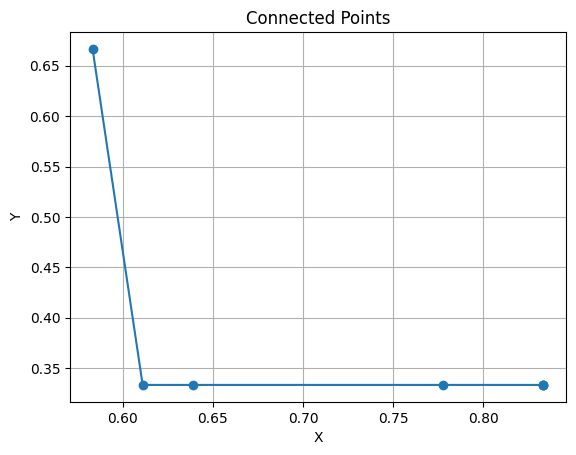

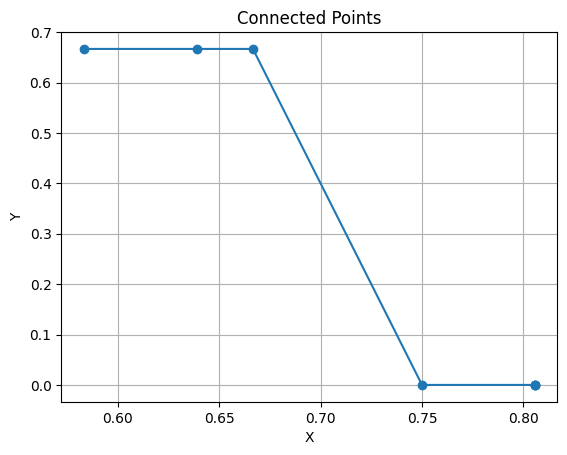

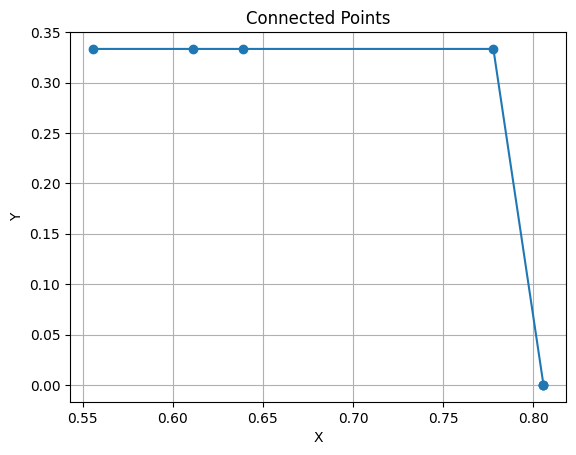

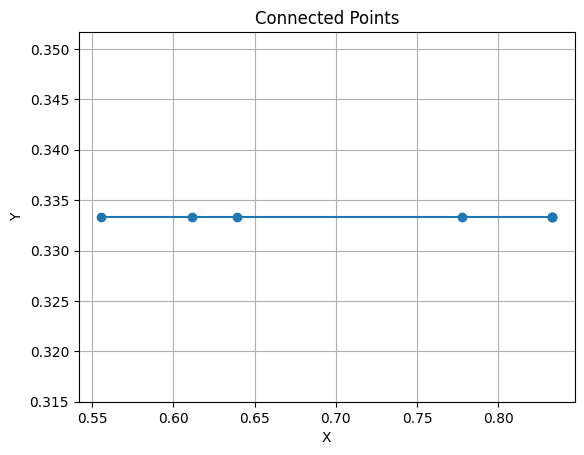

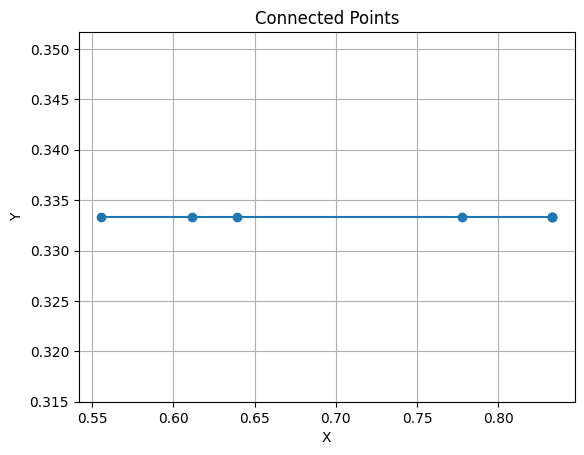

[0.4444444444444444, 0.38888888888888884, 0.5277777777777778, 0.3055555555555556, 0.2222222222222222, 0.2222222222222222, 0.3055555555555556, 0.5277777777777778]
[0.0, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.0, 0.0]


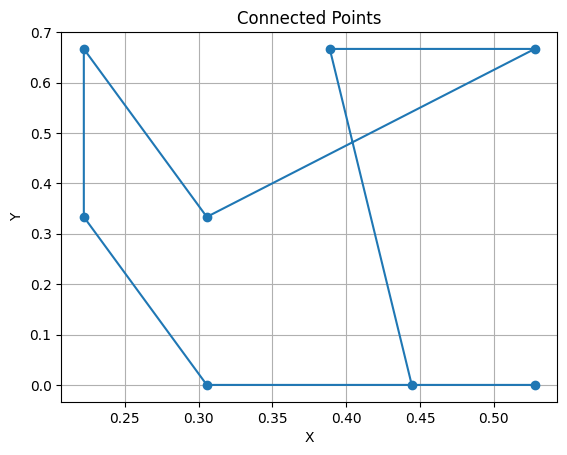

[0.4722222222222222, 0.38888888888888884, 0.5, 0.33333333333333337, 0.25, 0.2777777777777778, 0.36111111111111116, 0.5555555555555556]
[0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.3333333333333333]


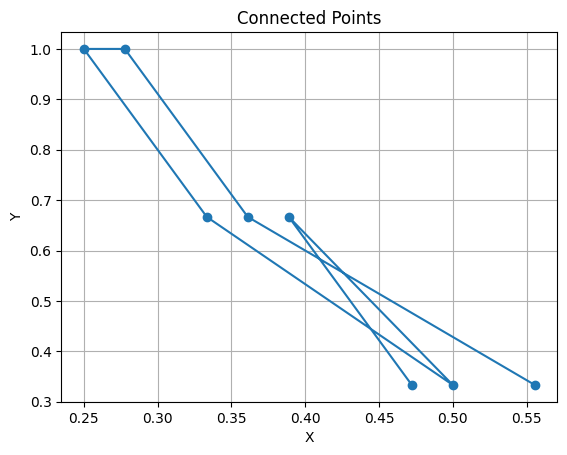

[0.4444444444444444, 0.33333333333333337, 0.4722222222222222, 0.2777777777777778, 0.19444444444444442, 0.19444444444444442, 0.33333333333333337, 0.5277777777777778]
[0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.3333333333333333, 0.0]


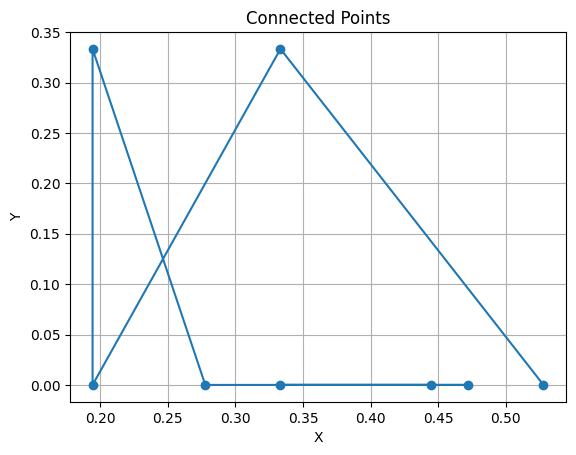

[0.5277777777777778, 0.41666666666666663, 0.5277777777777778, 0.33333333333333337, 0.25, 0.2777777777777778, 0.38888888888888884, 0.5833333333333333]
[1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6666666666666666]


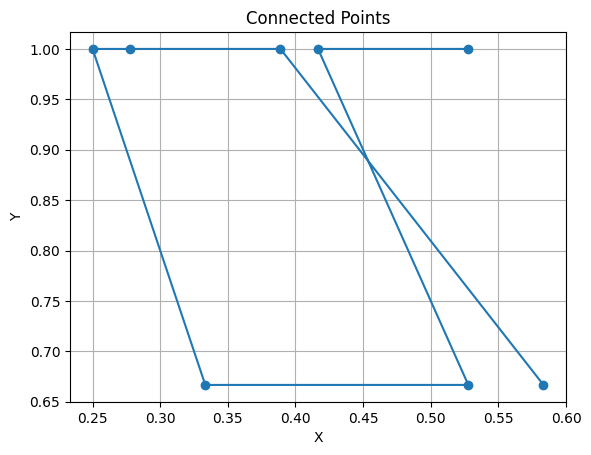

[0.5, 0.41666666666666663, 0.5277777777777778, 0.36111111111111116, 0.25, 0.25, 0.36111111111111116, 0.6111111111111112]
[0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 1.0]


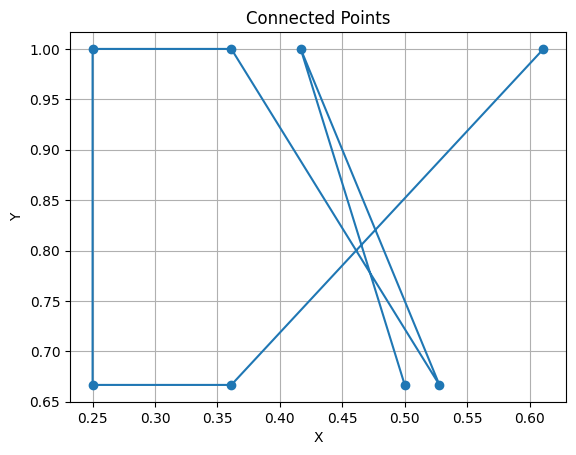

[0.5, 0.38888888888888884, 0.5, 0.36111111111111116, 0.25, 0.2777777777777778, 0.38888888888888884, 0.5833333333333333]
[0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666]


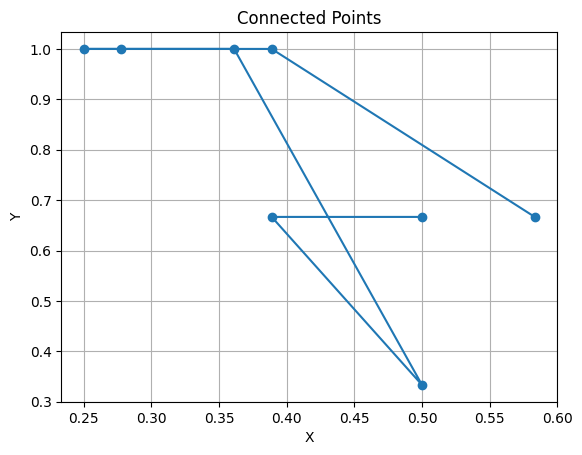

[0.4444444444444444, 0.33333333333333337, 0.4722222222222222, 0.33333333333333337, 0.25, 0.2777777777777778, 0.36111111111111116, 0.5555555555555556]
[0.0, 0.0, 0.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.3333333333333333]


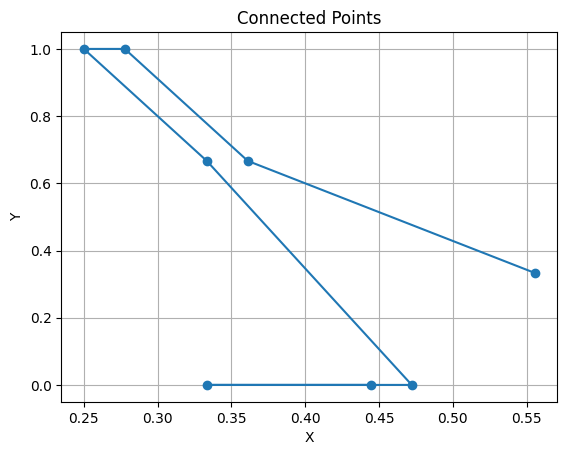

[0.5, 0.38888888888888884, 0.5277777777777778, 0.33333333333333337, 0.19444444444444442, 0.25, 0.36111111111111116, 0.5555555555555556]
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333]


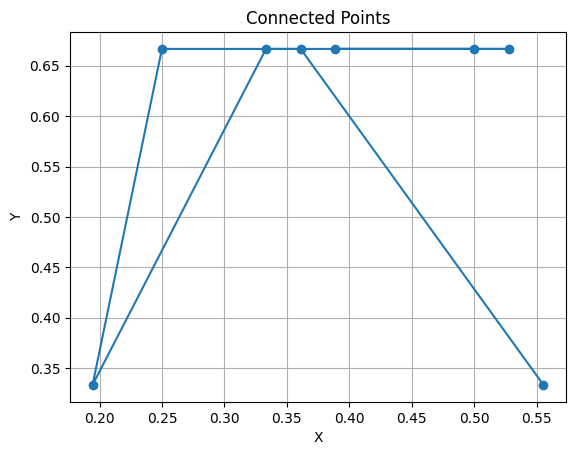

[0.5, 0.38888888888888884, 0.5555555555555556, 0.36111111111111116, 0.25, 0.2777777777777778, 0.36111111111111116, 0.5833333333333333]
[0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666]


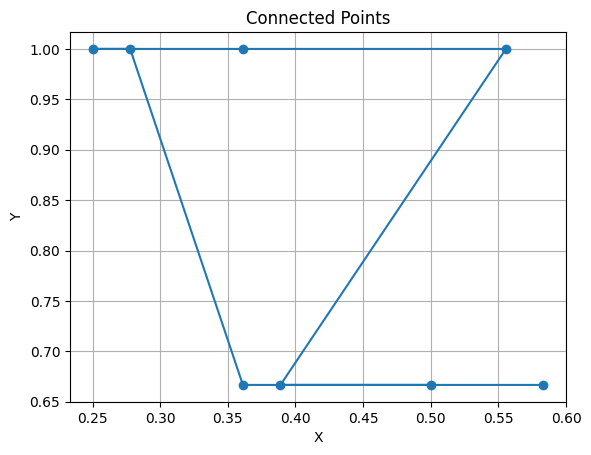

[0.5, 0.38888888888888884, 0.5277777777777778, 0.33333333333333337, 0.2222222222222222, 0.2777777777777778, 0.38888888888888884, 0.5833333333333333]
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666]


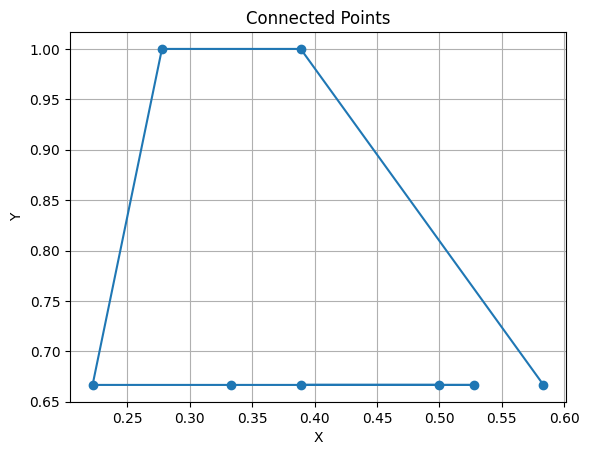

[0.4722222222222222, 0.36111111111111116, 0.5, 0.3055555555555556, 0.19444444444444442, 0.2222222222222222, 0.33333333333333337, 0.5555555555555556]
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


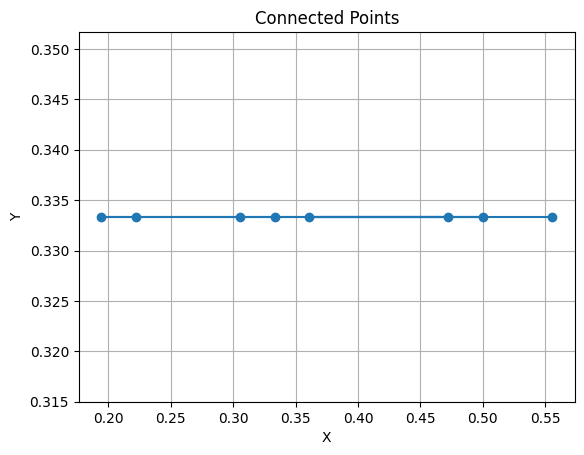

[0.5277777777777778, 0.41666666666666663, 0.5, 0.36111111111111116, 0.25, 0.2777777777777778, 0.36111111111111116, 0.5555555555555556]
[1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.6666666666666666, 0.3333333333333333]


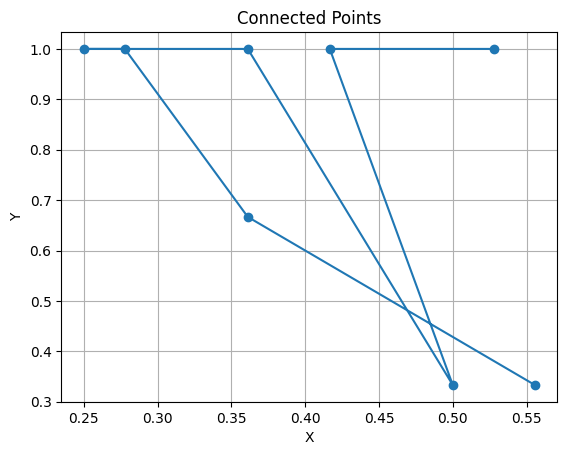

[0.5, 0.38888888888888884, 0.5277777777777778, 0.33333333333333337, 0.2222222222222222, 0.25, 0.36111111111111116, 0.5555555555555556]
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333]


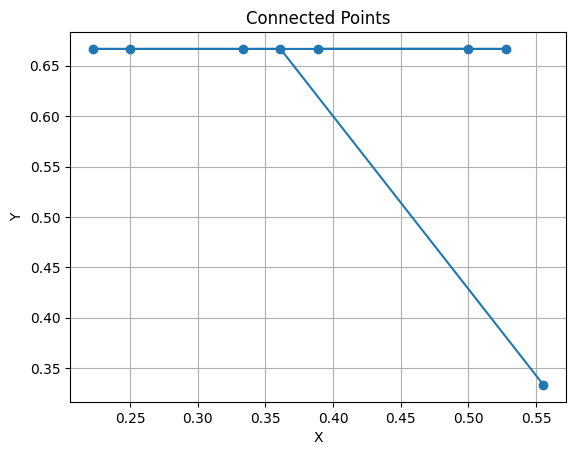

In [41]:
import matplotlib.pyplot as plt

dic1,dic2=classi.roc(X=X_test_total,y=y_test_total,Eigen_threshold_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],min_distance_threshould_list=[0,5,10,15,20,25,30,35,40,45,50,55,60])
for subject in dic2.values():
# Extract x and y coordinates from the data
    x = [point[0] for point in subject]
    y = [point[1] for point in subject]

# Plot the points
    plt.plot(x, y, marker='o')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Connected Points')
    plt.grid(True)
    plt.show()
for subject in dic1.values():
# Extract x and y coordinates from the data
    x = [point[0] for point in subject]
    y = [point[1] for point in subject]
    print(x)
    print(y)
# Plot the points
    plt.plot(x, y, marker='o')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Connected Points')
    plt.grid(True)
    plt.show()


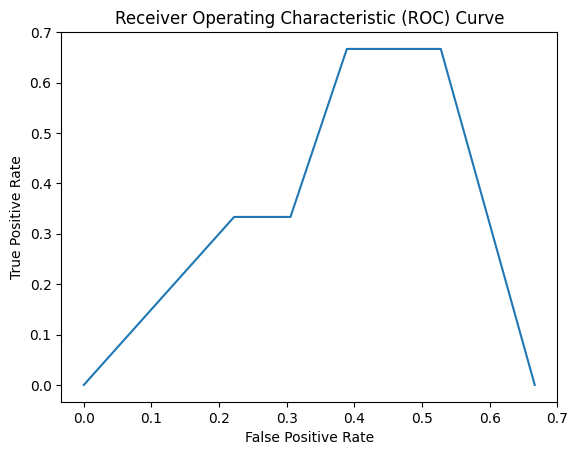

In [42]:
import matplotlib.pyplot as plt

fpr = [0.0, 0.2222222222222222, 0.3055555555555556, 0.38888888888888884, 0.4444444444444444, 0.5277777777777778, 0.5277777777777778, 0.6666666666666666]
tpr = [0.0, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.0]

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


In [11]:
# joblib.dump(classi , "test.pkl")

In [12]:
# model = joblib.load("model.pkl")

In [13]:
from sklearn.calibration import label_binarize


def roc_curve( X, y):
    
    
    #     # Categorize the test data based on classes
    unique_classes = np.unique(y)

    # # Binarize the labels for each class
    # y_test_bin = label_binarize(y, classes=unique_classes)
    
    #create a 2D list that holde the image of each category and the corresponding label
    #then pass these images in each list to the predict function and then get its y_pred
    # now for each class we have the image itself , the true label (in the 2D array) and the predicted label saved somehow for this specific category
    
    # y_scores = model.predict(X)
    # Initialize a 2D list to hold images and corresponding labels for each category
    category_data = []

    # Iterate over each category
    for category in unique_classes:
        # Get images and labels for the current category
        category_images, category_labels = get_category_images_and_labels(X, y, category)
        
        # Predict labels for the current category
        y_pred_category = model.predict(category_images)
        
        # Store the images, true labels, and predicted labels for the current category
        category_data.append({
            'true_labels': category_labels,
            'predicted_labels': y_pred_category
        })
    # print(category_data)
    subject_data = {}

    # Iterate over each category data
    for category_info in category_data:
        # Extract the true label (subject ID)
        true_label = category_info['true_labels'][0]
        subject_id = true_label.split('.')[0]
        
        # Check if subject ID exists in subject_data
        if subject_id not in subject_data:
            # If subject ID doesn't exist, initialize a new entry
            subject_data[subject_id] = {
                'true_labels': [],
                'predicted_labels': []
            }
        
        # Append information to the corresponding subject ID entry
        subject_data[subject_id]['true_labels'].extend(category_info['true_labels'])
        subject_data[subject_id]['predicted_labels'].extend(category_info['predicted_labels'])
    print(subject_data.keys())
    # Iterate over each subject
    for subject_key in subject_data.keys():
        print(f"Subject: {subject_key}")
        
        # Extract true labels and predicted labels
        true_labels = np.array([label for label in subject_data[subject_key]['true_labels']])
        pred_labels = np.array([label for label in subject_data[subject_key]['predicted_labels']])
        
        true_labels = label_binarize(true_labels, classes=unique_classes)
        pred_labels = label_binarize(pred_labels, classes=unique_classes)
        
        # Calculate ROC and related metrics
        fpr, tpr, roc_auc = calculate_roc(true_labels, pred_labels)
        
        # Print AUC for each subject
        print(f"AUC: {roc_auc}")


        


In [14]:
model.roc_curve(X_test,y_test)

NameError: name 'model' is not defined

In [ ]:
model.score(X_test,y_test)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def compute_roc_curve( y_true, y_scores):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Compute area under the curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()  

In [ ]:
# Testing the Eigenfaces model and displaying results
num_columns = 8
num_rows = (len(X_test) + num_columns - 1) // num_columns  # Calculate number of rows needed
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 2 * num_rows))

for i, (x, true_label) in enumerate(zip(X_test, y_test)):
    row = i // num_columns
    col = i % num_columns

    # Show the image being tested
    axes[row, col].imshow(x, cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'True: {true_label[:10]}')

    # Predict label for the test image
    predicted_label = classi.predict(x)[0][0] 

    # Show the predicted label
    axes[row, col].text(0.5, -0.2, f'Pred: {predicted_label}', fontsize=10, ha='center', va='center', transform=axes[row, col].transAxes)

plt.tight_layout()
plt.show()



# end of code

In [ ]:

import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from FaceDetection import OfflineFaceDetection
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

class EigenFaceRecognition:
    def __init__(self, faces_dir, test_dir):
        self.faces_dir = faces_dir
        self.test_dirs = test_dir

    def preprocess_images(self):
        preprocessed_images = []
        labels = []
        for label, person_dir in enumerate(os.listdir(self.faces_dir)):
            person_path = os.path.join(self.faces_dir, person_dir)
            if os.path.isdir(person_path):
                for filename in os.listdir(person_path):
                    img_path = os.path.join(person_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (500, 500))
                        preprocessed_images.append(img.flatten())
                        labels.append(label)
                    else:
                        print(f"Warning: Unable to read image '{img_path}'. Skipping...")
        if not preprocessed_images:
            print("Error: No valid images found in the specified directory.")
            return None, None
        return np.array(preprocessed_images), np.array(labels)

    def train_classifier(self, labels):
        pca = None
        # Load PCA object from file
        with open('../pca_model.pkl', 'rb') as f:
            pca = pickle.load(f)
        projected_images = np.load("../projected_images.npy")

        classifier = SVC(kernel='rbf')  # Use SVM with a radial basis function kernel
        classifier.fit(projected_images, labels)
        return pca, classifier

    def recognize_faces(self, pca, classifier, test_image):
        try:
            # Resize and preprocess the test image
            preprocessed_test_image = cv2.resize(test_image, (500, 500)).flatten().reshape(1, -1)

            # Project the test image onto the eigenfaces
            projected_test_image = pca.transform(preprocessed_test_image)

            # Predict the label using the trained classifier
            predicted_label = classifier.predict(projected_test_image)
            return predicted_label

        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    def calculate_roc_curves_for_classes(self, pca, classifier, test_data, test_labels):
        roc_curves = {}

        # Project the test data onto the eigenfaces
        projected_test_data = pca.transform(test_data)
        test_labels = np.array(test_labels)
        # Iterate over each class
        for class_label in range(len(classifier.classes_)):
            # Create binary labels (1 for the target class, 0 for other classes)
            binary_labels = (test_labels == class_label).astype(int)

            # Get decision scores for the binary classification problem
            decision_scores = classifier.decision_function(projected_test_data)

            # Calculate ROC curve for the binary classification problem
            fpr, tpr, _ = roc_curve(binary_labels, decision_scores[:, class_label])

            # Calculate AUC score for the binary classification problem
            auc_score = auc(fpr, tpr)

            # Store the ROC curve and AUC score
            roc_curves[class_label] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_score}

        return roc_curves

    def load_test_data(self):
        test_data_list = []
        test_labels_list = []
        for label, person_dir in enumerate(os.listdir(self.test_dirs)):
            person_path = os.path.join(self.test_dirs, person_dir)
            print(person_path)
            for filename in os.listdir(person_path):
                img_path = os.path.join(person_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (500, 500))
                    test_data_list.append(img.flatten())
                    test_labels_list.append(label)
                else:
                    print(f"Warning: Unable to read image '{img_path}'. Skipping...")
            # test_data_list.append(np.array(test_images))
            # test_labels_list.append(np.array(labels).flatten())
        return test_data_list, test_labels_list



In [ ]:
# class Eigenfaces:
#     def __init__(self):
#         self.pca_compunant_dictionary={}
        
#     def fit(self,X,y,Eigen_threshold=0.90,min_distance_threshould=25):
#         flatten_images=[image.flatten() for image in X]
#         flatten_images = np.vstack(flatten_images)
#         self.mean_image=np.mean(flatten_images, axis=0)
#         flatten_images_centroid = flatten_images - self.mean_image
#         coverance_matrix=(flatten_images_centroid.T@flatten_images_centroid)/(len(X)-1)        
        eigenValues, eigenVectors = np.linalg.eig(coverance_matrix)
        eigenValues_sum=sum(eigenValues)
        used_eigenValues=[]
        self.used_eigenVectors=[]
        zipped_data = list(zip(eigenValues, eigenVectors))
        zipped_data.sort(reverse=True)
        eigenValues, eigenVectors = zip(*zipped_data)
#         reached_sum=0
#         for i,j in zip(eigenValues, eigenVectors):
#             if(reached_sum<Eigen_threshold*eigenValues_sum):
#                 used_eigenValues.append(i)
#                 self.used_eigenVectors.append(j)
#                 reached_sum+=i
#             else:
#                 break
#         for i,label in enumerate(y):
#             self.pca_compunant_dictionary[label]=[]
#             for vector in self.used_eigenVectors:
#                 weight=(flatten_images[i]-self.mean_image)@vector
#                 self.pca_compunant_dictionary[label].append(weight)

#     def predict(self, X):
#         predictions = []
#         for x in X:
#             x_flat = cv2.resize(x, (100, 100)).flatten()
#             value_weights = []
#             for vector in self.used_eigenVectors:
#                 weight = (x_flat - self.mean_image) @ vector
#                 value_weights.append(weight)
#             label_distance_dic = {}
#             for label, weights in self.pca_compunant_dictionary.items():
#                 distance = np.sqrt(np.sum((np.array(weights) - np.array(value_weights)) ** 2))
#                 label_distance_dic[label] = distance
#             sorted_dict = sorted(label_distance_dic.items(), key=lambda item: item[1])
#             if abs(sorted_dict[0][1])>min_distance_threshould:
#                 predictions.append("not in the data set")
#             else:
#                 predictions.append(sorted_dict[0][0][:9])  #   Take the top prediction
#         return predictions

#     def predict_proba(self, X):
#         proba = []
#         for x in X:
#             x_flat = cv2.resize(x, (100, 100)).flatten()
#             value_weights = []
#             for vector in self.used_eigenVectors:
#                 weight = (x_flat - self.mean_image) @ vector
#                 value_weights.append(weight)
#             label_distance_dic = {}
#             for label, weights in self.pca_compunant_dictionary.items():
#                 distance = np.sqrt(np.sum((np.array(weights) - np.array(value_weights)) ** 2))
#                 label_distance_dic[label] = distance
#             # Compute softmax probabilities based on distances
#             distances = np.array([label_distance_dic[label] for label in self.pca_compunant_dictionary.keys()])
#             exp_distances = np.exp(-distances)
#             softmax = exp_distances / np.sum(exp_distances)
#             proba.append({label: p for label, p in zip(self.pca_compunant_dictionary.keys(), softmax)})
#         return proba
    
    
#     def score(self, X, y):
#         predictions = self.predict(X)
#         correct = sum(1 for pred, true in zip(predictions, y) if pred == true[:9] )
#         return correct / len(y)
    
#     def roc_curve(self, X, y):
#         y_scores = self.predict_proba(X)
#         fpr, tpr, thresholds = roc_curve(y, y_scores, pos_label='positive class label')
#         roc_auc = auc(fpr, tpr)
#         return fpr, tpr, roc_auc

#     def get_category_images_and_labels(self,X, y, category):
#             # Initialize lists to hold images and corresponding labels
#         images = []
#         labels = []
        
#         # Iterate over the dataset and collect images and labels for the specified category
#         for image, label in zip(X, y):
#             if category in label:
#                 images.append(image)
#                 labels.append(label)
        
#         return images, labels
    
#     def calculate_roc(self,true_labels, pred_labels):
#         # Calculate the ROC curve
#         fpr, tpr, thresholds = self.roc_curve(true_labels, pred_labels)
#         # Calculate the Area Under Curve (AUC)
#         roc_auc = auc(fpr, tpr)
        
#         return fpr, tpr, roc_auc
    
#     def roc_curve(self, X, y):

#         unique_classes = np.unique(y)

        
#         # y_scores = self.predict(X)
#         # Initialize a 2D list to hold images and corresponding labels for each category
#         category_data = []

#         # Iterate over each category
#         for category in unique_classes:
#             # Get images and labels for the current category
#             category_images, category_labels = self.get_category_images_and_labels(X, y, category)
            
#             # Predict labels for the current category
#             y_pred_category = self.predict(category_images)
            
#             # Store the images, true labels, and predicted labels for the current category
#             category_data.append({
#                 category: [category_labels , y_pred_category],
#             })
#             self.calculate_roc(category_labels , y_pred_category)
        

In [ ]:
class Eigenfaces:
    def __init__(self):
        self.pca_compunant_dictionary={}
        self.eigenValues, self.eigenVectors=None,None
        self.min_distance_threshould=None
        
    def fit(self,X,y,Eigen_threshold=0.90,min_distance_threshould=25):
        self.min_distance_threshould=min_distance_threshould
        flatten_images=[cv2.resize(image, (100, 100)).flatten() for image in X]
        flatten_images = np.vstack(flatten_images)
        self.mean_image=np.mean(flatten_images, axis=0)
        self.flatten_images_centroid = flatten_images - self.mean_image
        coverance_matrix=(self.flatten_images_centroid.T@self.flatten_images_centroid)/(len(X)-1)        
        self.eigenValues, self.eigenVectors = np.linalg.eig(coverance_matrix)
        self.eigenValues_sum=sum(self.eigenValues)
        used_eigenValues=[]
        self.used_eigenVectors=[]
        zipped_data = list(zip(self.eigenValues,self.eigenVectors))
        # zipped_data.sort(reverse=True)
        # self.eigenValues, self.eigenVectors = zip(*zipped_data)
        indices = np.argsort([eigenValue for eigenValue, _ in zipped_data])[::-1]
        self.eigenValues = np.array([self.eigenValues[i] for i in indices])
        self.eigenVectors = np.array([self.eigenVectors[i] for i in indices])
        print(len(self.eigenVectors))
        print(len(self.eigenValues))
        print(self.eigenValues)
        # self.flatten_images_centroid=flatten_images
        self.y=y

        reached_sum=0
        for i,j in zip(self.eigenValues, self.eigenVectors):
            if(reached_sum<Eigen_threshold*self.eigenValues_sum):
                used_eigenValues.append(i)
                self.used_eigenVectors.append(j)
                reached_sum+=i
            else:
                break
        for i,label in enumerate(self.y):
            self.pca_compunant_dictionary[label]=[]
            for vector in self.used_eigenVectors:
                weight=(self.flatten_images_centroid[i])@vector
                self.pca_compunant_dictionary[label].append(weight)

    def change_threshould(self,Eigen_threshold=None,min_distance_threshould=None):
        if self.eigenValues is None:
            print("you should fit model first")
        else:
            if Eigen_threshold is None and min_distance_threshould is None:
                print("no change happend")
            else:
                if min_distance_threshould is not None:
                    self.min_distance_threshould=min_distance_threshould
                if Eigen_threshold is not None:
                    reached_sum=0
                    used_eigenValues=[]
                    self.used_eigenVectors=[]
                    for i,j in zip(self.eigenValues, self.eigenVectors):
                        if(reached_sum<Eigen_threshold*self.eigenValues_sum):
                            self.used_eigenVectors.append(j)
                            reached_sum+=i
                        else:
                            break
                    for i,label in enumerate(self.y):
                        self.pca_compunant_dictionary[label]=[]
                        for vector in self.used_eigenVectors:
                            weight=(self.flatten_images_centroid[i])@vector
                            self.pca_compunant_dictionary[label].append(weight)
                print(len(self.used_eigenVectors))
                print("changes saved")
            


    def predict(self, X):
        predictions = []
        for x in X:
            x_flat = cv2.resize(x, (100, 100)).flatten()
            value_weights = []
            for vector in self.used_eigenVectors:
                weight = (x_flat - self.mean_image) @ vector
                value_weights.append(weight)
            label_distance_dic = {}
            for label, weights in self.pca_compunant_dictionary.items():
                distance = np.sqrt(np.sum((np.array(weights) - np.array(value_weights)) ** 2))
                label_distance_dic[label] = distance
            sorted_dict = sorted(label_distance_dic.items(), key=lambda item: item[1])
            if abs(sorted_dict[0][1])>self.min_distance_threshould:
                predictions.append("not in the data set")
            else:
                predictions.append(sorted_dict[0][0][:9])  #   Take the top prediction
        return predictions
    
    def score(self, X, y):
        predictions = self.predict(X)
        correct = sum(1 for pred, true in zip(predictions, y) if pred == true[:9] )
        return correct / len(y)



    def confusion_matrix(self,X,y):
        confusion_matrix_dic={}
        predictions = self.predict(X)
        confusion_matrix_dic["not in the data set"]={"true_positive":0,"false_negative":0}
        confusion_matrix_dic["sum"]={"true_positive":0,"false_negative":0}
        for index,true in enumerate(y):
            if true[:9] not in confusion_matrix_dic:
                confusion_matrix_dic[true[:9]]={"true_positive":0,"false_negative":0}
            if true[:9]==predictions[index]:
                confusion_matrix_dic[true[:9]]["true_positive"]+=1
                confusion_matrix_dic["sum"]["true_positive"]+=1
            else:
                confusion_matrix_dic[true[:9]]["false_negative"]+=1
                confusion_matrix_dic["sum"]["false_negative"]+=1
        return confusion_matrix_dic
    
    def roc(self,X,y,Eigen_threshold_list=None,min_distance_threshould_list=None):
        if Eigen_threshold_list is None and min_distance_threshould_list is None:
            print("make list for roc")
        else:
            min_distance_threshould_roc={}
            Eigen_threshold_roc={}
            if Eigen_threshold_list is not None:
                for threshold in Eigen_threshold_list:
                    self.change_threshould(Eigen_threshold=threshold)
                    confusion_matrix_dic=self.confusion_matrix(X,y)
                    for person_class in confusion_matrix_dic.keys():
                        if person_class!="not in the data set" and person_class!="sum" :
                            if person_class not in Eigen_threshold_roc:
                                Eigen_threshold_roc[person_class]=[]
                            Sensitivity= confusion_matrix_dic[person_class]["true_positive"]/(confusion_matrix_dic[person_class]["true_positive"]+confusion_matrix_dic[person_class]["false_negative"])
                            Specificity=(confusion_matrix_dic["sum"]["true_positive"]-confusion_matrix_dic[person_class]["true_positive"])/((confusion_matrix_dic["sum"]["true_positive"]-confusion_matrix_dic[person_class]["true_positive"])+(confusion_matrix_dic["sum"]["false_negative"]-confusion_matrix_dic[person_class]["false_negative"]))
                            Eigen_threshold_roc[person_class].append((1-Specificity,Sensitivity))

                if min_distance_threshould_list is not None:
                    for threshold in min_distance_threshould_list:
                        self.change_threshould(min_distance_threshould=threshold)
                        confusion_matrix_dic=self.confusion_matrix(X,y)
                        for person_class in confusion_matrix_dic.keys():
                             if person_class!="not in the data set" and person_class!="sum":
                                if person_class not in min_distance_threshould_roc:
                                    min_distance_threshould_roc[person_class]=[]
                                Sensitivity= confusion_matrix_dic[person_class]["true_positive"]/(confusion_matrix_dic[person_class]["true_positive"]+confusion_matrix_dic[person_class]["false_negative"])
                                Specificity=(confusion_matrix_dic["sum"]["true_positive"]-confusion_matrix_dic[person_class]["true_positive"])/((confusion_matrix_dic["sum"]["true_positive"]-confusion_matrix_dic[person_class]["true_positive"])+(confusion_matrix_dic["sum"]["false_negative"]-confusion_matrix_dic[person_class]["false_negative"]))
                                min_distance_threshould_roc[person_class].append((1-Specificity,Sensitivity))

            return Eigen_threshold_roc,min_distance_threshould_roc